In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from fact.io import read_h5py
exec(open('/home/msackel/Desktop/gammaClassification/programm/theta_cut/theta_cut.py').read())
exec(open('/home/msackel/Desktop/gammaClassification/programm/model_significance/model_significance.py').read())
plt.style.use('msackel')
%matplotlib inline

with open('/home/msackel/Desktop/gammaClassification/config/feature.yaml') as f:
    feature = yaml.load(f)

mc_hadron= pd.read_hdf('/home/msackel/Desktop/gammaClassification/data/raw_data/proton_precuts.hdf5')[feature+['theta_deg']]
mc_gammas= pd.read_hdf('/home/msackel/Desktop/gammaClassification/data/raw_data/gamma_precuts.hdf5')[feature+['theta_deg']]
mc_hadron['label'] = 0
mc_gammas['label'] = 1

In [8]:
eval_data = read_h5py(
				'/home/msackel/Desktop/gammaClassification/data/raw_data/crab_precuts.hdf5',
				key='events',
				columns=list(feature) + [
						'theta_deg',
						'theta_deg_off_1',
						'theta_deg_off_2',
						'theta_deg_off_3',
						'theta_deg_off_4',
						'theta_deg_off_5',
						]
				)

In [4]:
corr_theta_pre = np.array([[],[]])
Tree = RandomForestClassifier(
    max_depth=15, 
    max_features=7, 
    criterion='entropy', 
    n_estimators=150, 
    n_jobs=30)
for x in np.linspace(0,6,20):
    data_cut_hadron = mc_hadron.query('theta_deg >= '+str(np.sqrt(x)))
    data = pd.concat([mc_gammas[:100000], data_cut_hadron[:100000]])
    Tree.fit(data[feature], data.label)
    eval_data['pred_tree'] = Tree.predict_proba(eval_data[feature])[:,1]
    pred_Tree = np.array([])
    for cut in np.linspace(0.0,1,100):
        on_data, off_data = split_on_off_source_independent(eval_data.query('pred_tree>= '+str(cut)), theta2_cut=0.03) 
        pred_Tree = np.append(pred_Tree, li_ma_significance(len(on_data), len(off_data), 0.2))
    corr_theta_pre= np.append(corr_theta_pre, [[x],[max(pred_Tree)]], axis=1)

In [18]:
data = pd.DataFrame(corr_theta_pre)
data.to_pickle('corr_theta_pre')

/home/msackel/.conda/envs/msackel/lib/python3.6/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


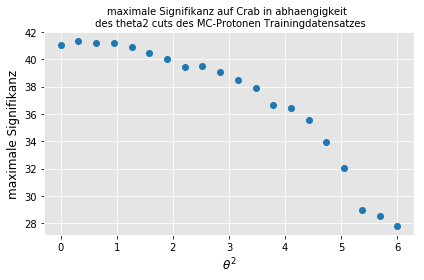

In [19]:
plt.plot(corr_theta_pre[0],corr_theta_pre[1], 'o')
plt.title('maximale Signifikanz auf Crab in abhaengigkeit \n des theta2 cuts des MC-Protonen Trainingdatensatzes')
plt.xlabel(r'$\theta^2$')
plt.ylabel(r'maximale Signifikanz')
plt.savefig('corr_sig_theta2.pdf')